Input Cell

In [28]:
import numpy as np
G=1
#masses of two bodies

m_1=2.0
m_2=2.5
#initial_position
x1=np.array([3.0,2.0])
x2=np.array([2.1,4.4])
#initial velocities
v1=np.array([4.0,-4.1])
v2=np.array([6.0,-7.2])
t_final=12


Data Generation (Using ODE Solver)

In [29]:
from scipy.integrate import solve_ivp
def two_body_ode_solver(t,y):
    r1 = y[0:2]
    r2 = y[2:4]
    v1 = y[4:6]
    v2 = y[6:8]

    r12 = r2 - r1
    dist = np.linalg.norm(r12)
    dist3 = dist**3

    # Newton's law of gravitation
    a1 = G * m_2 * r12 / dist3
    a2 = -G * m_1 * r12 / dist3

    dydt = np.concatenate([v1, v2, a1, a2])
    return dydt
    #Solve the ode

y0 = np.concatenate([x1, x2, v1, v2])  # Initial state vector
t_span=(0,t_final)
t_eval=np.linspace(0,t_final,1000)
sol = solve_ivp(two_body_ode_solver,t_span,y0, t_eval=t_eval, rtol=1e-9, atol=1e-9)
sol
print(t_eval.shape)

(1000,)


Split the dataset

In [30]:
import numpy as np
import torch


In [31]:
# Example: 80% training, 20% testing
train_frac = 0.8
n_total = len(t_eval)
n_train = int(n_total * train_frac)

train_time = t_eval[:n_train].reshape(-1, 1)
test_time = t_eval[n_train:].reshape(-1, 1)

# Output: full state = [x1, y1, x2, y2, vx1, vy1, vx2, vy2]
train_state = sol.y[:, :n_train].T   # shape: (n_train, 8)
test_state = sol.y[:, n_train:].T    # shape: (n_test, 8)

# Convert to PyTorch tensors
X_train = torch.tensor(train_time, dtype=torch.float32)
Y_train = torch.tensor(train_state, dtype=torch.float32)

X_test = torch.tensor(test_time, dtype=torch.float32)
Y_test = torch.tensor(test_state, dtype=torch.float32)


In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([800, 1])
torch.Size([800, 8])
torch.Size([200, 1])
torch.Size([200, 8])


define model

In [33]:
import torch.nn as nn

class TimeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 8)  # Output: [x1, y1, x2, y2, vx1, vy1, vx2, vy2]
        )

    def forward(self, t):
        return self.net(t)


ODE Loss

In [34]:

def ode_residual_loss(model, t):
    # Ensure t requires gradients to compute derivatives w.r.t t
    t = t.clone().detach().requires_grad_(True)

    pred = model(t)  # shape: (n_samples, 8)

    # Compute gradient of predictions w.r.t. input time t
    pred_derivatives = []
    for i in range(pred.shape[1]):
        grad_pred_i = torch.autograd.grad(
            outputs=pred[:, i],
            inputs=t,
            grad_outputs=torch.ones_like(pred[:, i]),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]  # Shape: (n_samples, 1)
        pred_derivatives.append(grad_pred_i)

    # Stack derivatives shape: (n_samples, 8, 1)
    pred_derivatives = torch.stack(pred_derivatives, dim=1).squeeze(-1)  # shape: (n_samples, 8)

    # Here, for example, check that derivative of position equals velocity
    # pred[:, :4] are positions; pred[:, 4:] are velocities
    pos_derivatives = pred_derivatives[:, :4]
    vel = pred[:, 4:]

    # Residual = difference between predicted velocity and derivative of position
    residual = pos_derivatives - vel
    ode_loss = torch.mean(residual**2)
    return ode_loss

In [39]:





# Initialize model, optimizer, and loss functions
model = TimeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mae_loss_fn = nn.L1Loss()  # For Mean Absolute Error
mse_loss_fn = nn.MSELoss()  # For general losses, if needed




for epoch in range(20000):
    model.train()

    # Predicting using the model
    pred_train = model(X_train)

    # Calculate MAE loss
    mae_loss = mae_loss_fn(pred_train, Y_train)

    # Calculate ODE residual loss
    ode_loss = ode_residual_loss(model, X_train)

    # Combine both losses
    total_loss = mae_loss + 0.1 * ode_loss  # Weighting ODE loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total Loss: {total_loss.item():.6f} | MAE Loss: {mae_loss.item():.6f} | ODE Loss: {ode_loss.item():.6f}")


Epoch 0 | Total Loss: 15.625790 | MAE Loss: 15.617618 | ODE Loss: 0.081716
Epoch 100 | Total Loss: 11.474283 | MAE Loss: 10.824642 | ODE Loss: 6.496406
Epoch 200 | Total Loss: 8.599400 | MAE Loss: 8.045840 | ODE Loss: 5.535589
Epoch 300 | Total Loss: 6.380915 | MAE Loss: 5.912914 | ODE Loss: 4.680010
Epoch 400 | Total Loss: 4.700191 | MAE Loss: 4.309734 | ODE Loss: 3.904567
Epoch 500 | Total Loss: 3.407672 | MAE Loss: 3.087323 | ODE Loss: 3.203493
Epoch 600 | Total Loss: 2.434185 | MAE Loss: 2.169883 | ODE Loss: 2.643018
Epoch 700 | Total Loss: 1.715097 | MAE Loss: 1.498649 | ODE Loss: 2.164487
Epoch 800 | Total Loss: 1.181943 | MAE Loss: 1.006202 | ODE Loss: 1.757409
Epoch 900 | Total Loss: 0.805194 | MAE Loss: 0.664853 | ODE Loss: 1.403413
Epoch 1000 | Total Loss: 0.541928 | MAE Loss: 0.436051 | ODE Loss: 1.058775
Epoch 1100 | Total Loss: 0.360678 | MAE Loss: 0.286712 | ODE Loss: 0.739657
Epoch 1200 | Total Loss: 0.246463 | MAE Loss: 0.192774 | ODE Loss: 0.536894
Epoch 1300 | Total L

In [40]:
import torch

T = 12.0  # final time you want to predict at
with torch.no_grad():
    model.eval()
    t_test = torch.tensor([[T]], dtype=torch.float32)  # shape (1, 1)
    pred = model(t_test)  # shape (1, 8), predicted [x1, y1, x2, y2, vx1, vy1, vx2, vy2]
    final_pos = pred[0, :4].numpy()  # positions only

    print(f"Predicted final positions at T={T}:")
    print(f"x1 = ({final_pos[0]:.4f}, {final_pos[1]:.4f})")
    print(f"x2 = ({final_pos[2]:.4f}, {final_pos[3]:.4f})")


Predicted final positions at T=12.0:
x1 = (64.5062, -41.3250)
x2 = (46.1081, -67.1890)


<ipython-input-41-3afd31dd97a9>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_all = torch.tensor(X_train, dtype=torch.float32)


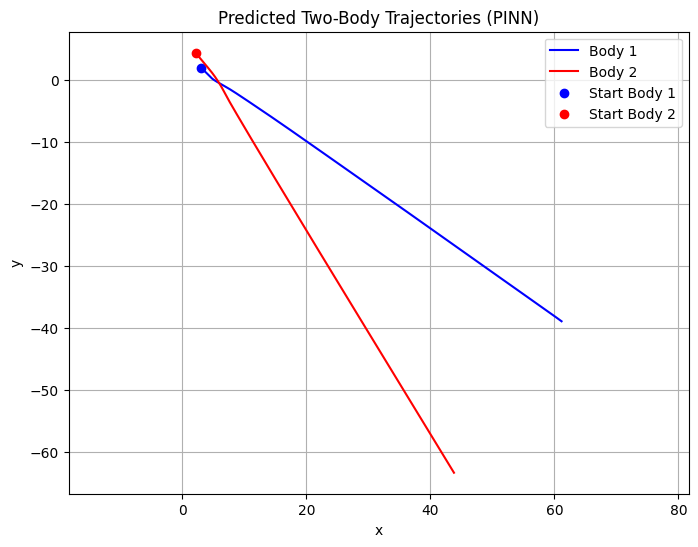

In [41]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    t_all = torch.tensor(X_train, dtype=torch.float32)
    predictions = model(t_all).numpy()

x1_pred, y1_pred = predictions[:, 0], predictions[:, 1]
x2_pred, y2_pred = predictions[:, 2], predictions[:, 3]

# predicted trajectory
plt.figure(figsize=(8, 6))
plt.plot(x1_pred, y1_pred, label="Body 1", color='blue')
plt.plot(x2_pred, y2_pred, label="Body 2", color='red')
plt.scatter(x1_pred[0], y1_pred[0], color='blue', marker='o', label='Start Body 1')
plt.scatter(x2_pred[0], y2_pred[0], color='red', marker='o', label='Start Body 2')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Two-Body Trajectories (PINN)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()